원본 데이터 'waimai_10k.csv'를 읽으면 관찰 데이터 규모는 11,87행, 2열이며 각 행에는 'label' 평가 유형이 포함되어 있으며 값이 1이면 호평, 값이 0이면 악평, 'review' 사용자 평가는 한자와 아라비아 숫자로 구성된 평가 텍스트입니다.

In [1]:
import pandas as pd
data = pd.read_csv('waimai_10k.csv',encoding='utf8')
print(data)

       label                                    review
0          1                              很快，好吃，味道足，量大
1          1                              没有送水没有送水没有送水
2          1                                  非常快，态度好。
3          1                           方便，快捷，味道可口，快递给力
4          1                              菜味道很棒！送餐很及时！
...      ...                                       ...
11982      0                        以前几乎天天吃，现在调料什么都不放，
11983      0  昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984      0                                 凉皮太辣,吃不下都
11985      0                              本来迟到了还自己点！！！
11986      0         肉夹馍不错，羊肉泡馍酱肉包很一般。凉面没想象中好吃。送餐倒是很快。

[11987 rows x 2 columns]


총 다음과 같은 준비 작업을 수행합니다.
1. [‘review’]열을 문자열 유형으로 변환하여 후속 분사 작업을 용이하게 합니다.

In [2]:
#유형을 문자열로 변환하여 분사 조작이 용이함
data['review'] = data['review'].astype('str')

2. 원본 데이터에 null 값이 있는지 확인하고 isnull() 함수를 사용한 결과는 0, 즉 null 값이 없습니다.

In [3]:
#빈 값이 있는지 보기
import numpy as np
np.sum(pd.isnull(data))#pd.isnull은 빈 값이 있는지 여부를 판단하는 데 사용됩니다.

label     0
review    0
dtype: int64

3. review 열을 reviews로 정의하고 lable 열을 sentiments로 정의하여 추후 사용이 편리합니다.

In [4]:
#평가와 감정을 정의하다
reviews = np.array(data['review'])
sentiments = np.array(data['label'])
row,col = data.shape

4. 원그래프를 그려 정방향과 음방향의 빈도와 점유율을 관찰한다.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: PingFang HK


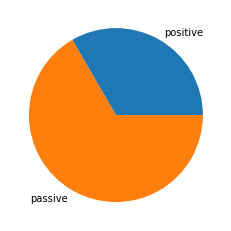

In [5]:
#양방향과 음방향 평가가 각각 얼마나 되는지 살펴본다
data['label'].value_counts()

#원형도를 그리면, 정방향과 음방향의 비율을 관찰할 수 있다.
import numpy as np
import matplotlib.pyplot as plt

#케이크 정의
plt.pie([4000,7987],labels = ('positive','passive'))
plt.rcParams['font.sans-serif'] = ['PingFang HK']

plt.show()


분사

In [6]:
#사용을 중지한 단어
stopwords = pd.read_csv("stopwords.txt",header=None,names=["StopWords"])

#분사를 저장할 열을 하나 더 추가합니다.
data['cutwords'] = "cutwords"

#jieba
import jieba
for ii in np.arange(row):
    cutwords = list(jieba.cut(data.review[ii],cut_all=True))
    cutwords = pd.Series(cutwords)[pd.Series(cutwords).apply(len)>1]
    cutwords = cutwords[~cutwords.isin(stopwords)]
    data.cutwords[ii] = str(cutwords.values)
print(data)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\Wrinkle\AppData\Local\Temp\jieba.cache
Loading model cost 0.686 seconds.
Prefix dict has been built successfully.
C:\Users\Wrinkle\AppData\Local\Temp\ipykernel_16692\2984009523.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.cutwords[ii] = str(cutwords.values)


       label                                    review  \
0          1                              很快，好吃，味道足，量大   
1          1                              没有送水没有送水没有送水   
2          1                                  非常快，态度好。   
3          1                           方便，快捷，味道可口，快递给力   
4          1                              菜味道很棒！送餐很及时！   
...      ...                                       ...   
11982      0                        以前几乎天天吃，现在调料什么都不放，   
11983      0  昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了   
11984      0                                 凉皮太辣,吃不下都   
11985      0                              本来迟到了还自己点！！！   
11986      0         肉夹馍不错，羊肉泡馍酱肉包很一般。凉面没想象中好吃。送餐倒是很快。   

                                                cutwords  
0                                       ['很快' '好吃' '味道']  
1                                       ['没有' '没有' '没有']  
2                                            ['非常' '态度']  
3                        ['方便' '快捷' '味道' '可口' '快递' '递给']  
4       

1. 나중에 얻은 점수 저장을 위해 데이터에 2개의 추가 변수(열)를 추가하고 각각 "숫자" 및 "숫자2"로 이름 지정 2. SnowNLP를 사용하여 평가 텍스트를 분석하고 SnowNLP 필드 "s" 반환 ; 3. 각 리뷰의 감정 점수인 s의 감정 속성을 읽어 숫자 변수에 저장

In [7]:
#pip install -i https://pypi.douban.com/simple --trusted-host pypi.douban.com snownlp

In [8]:
#사용 SnowNLP
from snownlp import SnowNLP

#한 줄 더 추가, 평점 저장
data['number'] = "number"

#SnowNLP를 이용하여 중국어 텍스트의 감정을 분석하여 내장된 sentiments에서 평점 획득
#채점범위는 0-1, 0에 가까우면 마이너스, 1에 가까우면 플러스
for i in np.arange(row):
    s = SnowNLP(reviews[i])
    number = s.sentiments
    data.number[i] = number
print(data)

C:\Users\Wrinkle\AppData\Local\Temp\ipykernel_16692\2704473992.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.number[i] = number


       label                                    review  \
0          1                              很快，好吃，味道足，量大   
1          1                              没有送水没有送水没有送水   
2          1                                  非常快，态度好。   
3          1                           方便，快捷，味道可口，快递给力   
4          1                              菜味道很棒！送餐很及时！   
...      ...                                       ...   
11982      0                        以前几乎天天吃，现在调料什么都不放，   
11983      0  昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了   
11984      0                                 凉皮太辣,吃不下都   
11985      0                              本来迟到了还自己点！！！   
11986      0         肉夹馍不错，羊肉泡馍酱肉包很一般。凉面没想象中好吃。送餐倒是很快。   

                                                cutwords    number  
0                                       ['很快' '好吃' '味道']  0.876089  
1                                       ['没有' '没有' '没有']  0.079422  
2                                            ['非常' '态度']  0.742487  
3                        ['

In [9]:
#number 값이 소수임을 관찰하고 이를 sentiments와 비교하기 위해 0-1형 데이터로 변환
#데이터 손상을 방지하기 위해 number2의 열을 복사하고 number와 대조할 수 있습니다.
data['number2'] = data['number'].copy()
#0-1형으로 전환, 결과 출력
data['number2'] = data['number2'].apply(lambda x: 0 if x<0.5 else 1)
data

label                                    review  \
0          1                              很快，好吃，味道足，量大   
1          1                              没有送水没有送水没有送水   
2          1                                  非常快，态度好。   
3          1                           方便，快捷，味道可口，快递给力   
4          1                              菜味道很棒！送餐很及时！   
...      ...                                       ...   
11982      0                        以前几乎天天吃，现在调料什么都不放，   
11983      0  昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了   
11984      0                                 凉皮太辣,吃不下都   
11985      0                              本来迟到了还自己点！！！   
11986      0         肉夹馍不错，羊肉泡馍酱肉包很一般。凉面没想象中好吃。送餐倒是很快。   

                                                cutwords    number  number2  
0                                       ['很快' '好吃' '味道']  0.876089        1  
1                                       ['没有' '没有' '没有']  0.079422        0  
2                                            ['非常' '态度']  0.742487        1  
3                        ['方便' '快捷' '味道' '可口' '快递' '递给']  0.244692        0  
4                                       ['味道' '很棒' '及时']  0.815827        1  
...                                                  ...       ...      ...  
11982               ['以前' '几乎' '天天' '现在' '调料' '什么' '不放']  0.523867        1  
11983  ['昨天' '凉皮' '两份' '什么' '调料' '没有' '麻油' '特别' '难吃' ...  0.026878        0  
11984                                  ['凉皮' '吃不下' '不下']  0.148821        0  
11985                             ['本来' '迟到' '自己' '！！！']  0.165718        0  
11986  ['肉夹馍' '不错' '羊肉' '泡馍' '酱肉' '肉包' '一般' '凉面' '没想'...  0.980709        1  

[11987 rows x 5 columns]

In [10]:
#number2(0-1로 전환한 후의 감정 점수)와 원본 sentiments의 차이 산출
#차이가 0이면 채점 결과가 올바르고 -1 또는 1이면 부정확함
chazhi = data['label'] - data['number2']

#차이의 경우를 세어 보면, 차이가 0인 경우가 9441개이다.
chazhi.value_counts()


 0    9441
-1    1469
 1    1077
dtype: int64

In [11]:
#차이가 0인 빈도(즉, 정확한 빈도 분석)를 총 표본량으로 나누어 정확도를 구한다.
print('SnowNLP 기반 감정 분석의 정확도는：',9441/11987)

SnowNLP 기반 감정 분석의 정확도는： 0.7876032368399098


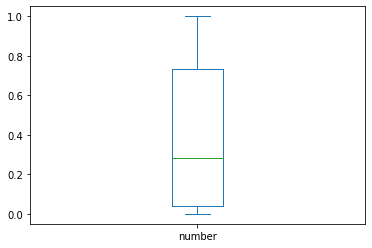

0    7595
1    4392
Name: number2, dtype: int64
중앙값(Median)：0.284120
낮은 사분위수(Q1)：0.038339
상위 사분위수(Q3)：0.732883
사분위 범위(IQR)：0.694544
최소값(Min)：0.000000
최대값(Max)：1.000000


In [12]:
#SnowNLP 감정평가 분석
#상자도
box_plot = data['number'].plot.box() 
plt.show() 

# 관련 지표를 관찰하다
print(data['number2'].value_counts())
LSTAT_q1 = data['number'].quantile(.25) 
LSTAT_q3 = data['number'].quantile(.75) 
LSTAT_iqr = LSTAT_q3-LSTAT_q1 
print("중앙값(Median)：%f" % data['number'].quantile(.5)) 
print("낮은 사분위수(Q1)：%f" % LSTAT_q1) 
print("상위 사분위수(Q3)：%f" % LSTAT_q3) 
print("사분위 범위(IQR)：%f" % LSTAT_iqr) 
print("최소값(Min)：%f" % data['number'].min()) 
print("최대값(Max)：%f" % data['number'].max()) 

SVM 기반 감성 분석

In [13]:
#테스트 세트 구축 트레이닝 세트
arr = np.arange(row)
np.random.shuffle(arr)
train_reviews = data['cutwords'][arr[:6000]]
train_sentiments = sentiments[arr[:6000]]
test_reviews = data['cutwords'][arr[5987:]]
test_sentiments = sentiments[arr[5987:]]

In [14]:
#특징 추출
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

train_reviews, test_reviews, train_sentiments, test_sentiments = train_test_split(data.cutwords, sentiments, test_size=0.20, random_state=2)

#훈련집에 BOW를 구축
cv = CountVectorizer(binary=False, min_df=0.0, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(train_reviews)

#트레이닝 세트에 TFIDF 구축
tv = TfidfVectorizer(use_idf=True, min_df=0.0, max_df=1.0, ngram_range=(1,2),sublinear_tf=True)
tv_train_features = tv.fit_transform(train_reviews)


#테스트 세트를 피쳐로 변환
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)


In [15]:
#훈련모델 및 예측
from sklearn.linear_model import SGDClassifier

svm = SGDClassifier(loss='hinge', max_iter=100)

svm.fit(cv_train_features,train_sentiments)
cv_predicted_sentiments = svm.predict(cv_test_features)  

svm.fit(tv_train_features,train_sentiments)
tv_predicted_sentiments = svm.predict(tv_test_features)  


In [16]:
#성능평가
from sklearn.metrics import confusion_matrix    
#난독화 행렬 함수 생성
cv_confusion = confusion_matrix(test_sentiments, cv_predicted_sentiments )
tv_confusion = confusion_matrix(test_sentiments, tv_predicted_sentiments )
print('단어 모음 기능 혼란 매트릭스：\n', cv_confusion)
print('TFIDF기능 혼란 행렬：\n', tv_confusion)
print('단어 모음 기능 테스트 세트 예측 정확도：', (cv_confusion[0,0]+cv_confusion[1,1])/cv_confusion.sum())
print('TFIDF기능 테스트 세트 예측 정확도：', (tv_confusion[0,0]+tv_confusion[1,1])/tv_confusion.sum())

단어 모음 기능 혼란 매트릭스：
 [[1459  132]
 [ 189  618]]
TFIDF기능 혼란 행렬：
 [[1490  101]
 [ 190  617]]
단어 모음 기능 테스트 세트 예측 정확도： 0.8661384487072561
TFIDF기능 테스트 세트 예측 정확도： 0.8786488740617181


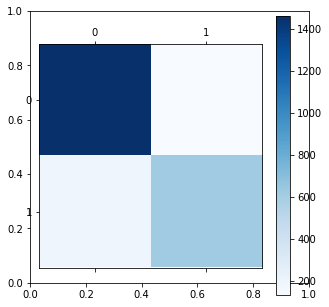

In [17]:
plt.figure(figsize=(5, 5))
ax = plt.gca() 
plt.matshow(cv_confusion, fignum=1,cmap=plt.cm.Blues)
plt.colorbar()

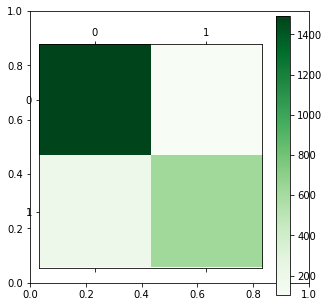

In [18]:
plt.figure(figsize=(5, 5))
ax = plt.gca() 
plt.matshow(tv_confusion, fignum=1,cmap=plt.cm.Greens)
plt.colorbar()


In [19]:
#테스트집, 트레이닝집 변경
test_reviews = data['cutwords'][arr[:6000]]
test_sentiments = sentiments[arr[:6000]]
train_reviews = data['cutwords'][arr[5987:]]
train_sentiments = sentiments[arr[5987:]]
cv_train_features = cv.fit_transform(train_reviews)
tv_train_features = tv.fit_transform(train_reviews)
cv_test_features = cv.transform(test_reviews)
tv_test_features = tv.transform(test_reviews)
svm.fit(cv_train_features,train_sentiments)
cv_predicted_sentiments = svm.predict(cv_test_features)
svm.fit(tv_train_features,train_sentiments)
tv_predicted_sentiments = svm.predict(tv_test_features)
cv_confusion = confusion_matrix(test_sentiments, cv_predicted_sentiments )
tv_confusion = confusion_matrix(test_sentiments, tv_predicted_sentiments )
print('단어 모음 기능 테스트 세트 예측 정확도：', (cv_confusion[0,0]+cv_confusion[1,1])/cv_confusion.sum())
print('TFIDF기능 테스트 세트 예측 정확도：', (tv_confusion[0,0]+tv_confusion[1,1])/tv_confusion.sum())

단어 모음 기능 테스트 세트 예측 정확도： 0.8625
TFIDF기능 테스트 세트 예측 정확도： 0.8725


In [20]:
#이전 분사 결과가 적용되지 않아 다시 분할
#먼저 모든 평가 텍스트를 한데 묶어라.
pin = '\n'.join(data['review'].tolist())

In [21]:
#스플라이 결과 pin으로 재분사
cutwords2 = pd.Series(list(jieba.cut(pin)))

#2이하 길이의 어휘를 체질한다
cutwords3 = cutwords2[cutwords2.str.len()>1]

In [22]:
#선별도구를 설치하여 무의미하거나 방해되는 어휘를 선별한다.
filtering = [
    '没有', '一个', '外卖', '一点', '东西', '不会', '怎么', '不是', '两个', '结果', '已经', '感觉', '就是', '特别', '而且', 
    '什么', '\n', '\t\n', '有点', '非常', '这么', '知道', '超级', '真的', '不要', '但是', '可以', '还是', '一次', '时候',
    '不能', '这个', '你们', '一样', '这次', '今天', '根本', '真是', '不过', '一份', '实在', '12', '11', '那么']


In [23]:
#분사결과 cutwords3로 선별할 어휘를 제거하여 유효한 어휘를 얻는다.cutwords4
cutwords4 = cutwords3[~cutwords3.str.contains('|'.join(filtering))]


In [24]:
#유효어휘 중 상위 50위까지 읽기
top50 = cutwords4.value_counts()[:50]
top50


味道     1592
送餐     1586
好吃     1563
不错     1256
小时     1245
送到      882
速度      743
难吃      610
一般      576
送来      571
太慢      566
时间      543
很快      481
配送      426
百度      423
态度      395
打电话     349
电话      341
服务      323
分钟      319
小哥      309
以后      302
快递      298
米饭      290
卷饼      277
差评      267
餐员      264
辛苦      262
包装      256
订单      231
里面      228
下次      224
师傅      201
煎饼      201
商家      193
自己      190
菜品      185
牛肉      182
不好      181
送达      180
订餐      180
肘子      179
口味      178
店里      178
喜欢      177
送过来     168
下单      166
这家      165
希望      161
骑士      158
dtype: int64

In [25]:
#유효어휘 중 100위권까지 읽기
top100 = cutwords4.value_counts()[:100]

#유효어휘 상위 100자리로 어운도에 맞는 데이터를 설정하고 데이터 유형을 변환
data_for_wordcloud = [(x, y) for x, y in zip(top100.index.tolist(), top100.tolist())]
data_for_wordcloud = str(data_for_wordcloud)


文件的编码格式:utf-8


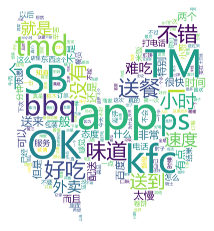

In [28]:
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image 
import numpy as np

f = open('critic.txt', 'r', encoding='utf-8')
print('encoding:' + f.encoding)
txt = f.read()
f.close()

words = jieba.lcut(txt)
counts = {}
chiyun = []
for word in words:
    if len(word) < 2:
        continue
    else:
        counts[word] = counts.get(word, 0) + 1

items = list(counts.items())

items.sort(key=lambda x: x[1], reverse=True)
#print("{0:<5}{1:<8}{2:<5}".format('序号', '词语', '频率'))

for i in range(len(items)):
    word, count = items[i]
    #print("{0:<5}{1:<8}{2:>5}".format(i + 1, word, count))
    chiyun.append(word)
maskph = np.array(Image.open('butterfly.jpg'))

text_cut = '/'.join(chiyun)
wordcloud = WordCloud(mask=maskph, background_color='white', font_path='msyh.ttc', width=1000, height=860, margin=2,
                      scale=4).generate(text_cut)
wordcloud.to_file("wordcloud.png")  
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

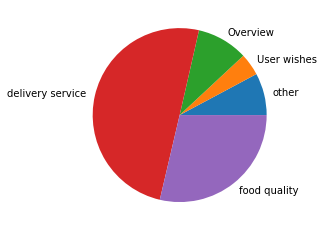

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.pie([1658,877,2013,10589,6084],labels = ('other', 'User wishes', 'Overview', 'delivery service', 'food quality'))

#plt.rcParams['font.sans-serif'] = ['BatangChe']

plt.show()